Just starting to think about how I can do this. 

# Collecting Stats From Previously Gathered Data

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np


In [2]:
def returnFullSeasonStats(teamName, yearArr):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        yearArr (array of ints): Allows to make sure we can pull specific year ranges
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #sets up first iteration so i only grab row labels one time
    firstSeasonStats = True
    firstSeasonInfo = True

    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        #makes sure we only grab the years we want
        if(int(file[-8:-4]) not in yearArr):
            continue
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
                firstSeasonStats = False
            elif not firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels before concecrating 
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
        else:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
                #once not the first season
                firstSeasonInfo = False
            elif not firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 


def returnSpecificRow(teamDataFrame, statName):
    """
    Goes into given dataframe and pulls out a requested row from the stat name

    Args:
        teamDataFrame (pandas Dataframe): passed dataframe that contains row to extract.
        statName (string): Name of row to extract 
    Returns:
        statPD: Pandas Data-Frame of row we want to extract
    """
    #mask to pull the spectific row we want, case insensitive
    mask = teamDataFrame["Unnamed: 1"].str.lower() == statName.lower()
    #creates the dataframe and ignores the first two labeling columns
    statPD = pd.DataFrame(teamDataFrame.loc[mask].iloc[:, 2:].values.flatten())
    return statPD


def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat

def getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, currTeam):
    """
    parses out a dataframes data includin the spread all the scores,
        the difference in game scores ect. 
    Args:
        currFullSeasonStats (pandas Dataframe): dataframe with all the stats from 
            potentially mutliple seasons.
        
        currFullSeasonInfo (pandas Dataframe): dataframe with all the game info from 
            potentially mutliple seasons. IE spread, weather, ect.

        currTeam (str): the name of team currently interested in
    Returns:
        teamBeatSpread (Dataframe): how many points team beat spread by. Postive means won
        scoreDifference (Dataframe): differnce between team score and opponent score across seasons
        vegasSpread (Dataframe): Vegas predicted point spread
        teamScoreFloat (Dataframe): team of interest scores throughout seasons
        oppScoreFloat (Dataframe): opponents scores throughout seasons
    """
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"].iloc[0]
    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")
    #getting total score
    teamScoreFloat = teamsScore[0].astype(float) 
    oppScoreFloat = opponentScore[0].astype(float)
    #getting actual spread
    scoreDifference = pd.DataFrame(teamScoreFloat - oppScoreFloat)
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")
    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)
    #takes out nan and label rows
    overUnderNumber = overUnderNumber
    vegasSpread = spreadNumber
    # print(vegasSpread)
    #convering spread to be in format as vegas. 
    for i in range(1,len(scoreDifference)):
        if ("nan" not in str(spread[0][i])) and currTeam not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]

    teamBeatSpread = scoreDifference[:] - vegasSpread[:]
    
    return teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat


def getConversionRates(currFullSeasonStats, statName):
    """
    Grabs and parses conversion rates into floats. Originally in x-y format (ie 3-10)
    This function coverts x-y --> x/y to get the rate of conversion as a float

    Args:
        currFullSeasonStats (pandas Dataframe): Dataframe with the stats from years selected
        statName (string): Name of row to extract 
    Returns:
        finalRate: Pandas Data-Frame of conversion rates in float form
    """
    #will store the conversion rate floats
    converRateFloatArr = []
    #grabs the selected conversion rate row
    converRate = returnSpecificRow(currFullSeasonStats, statName)
    for i in range(len(converRate)):
        #finds the - splitting 
        index = converRate[0][i].find("-")
        if(int(converRate[0][i][index +1:]) == 0):
            #if there were zero attemps to convert (mainly for 4th down)
            converRateFloatArr.append(np.nan)
        else:
            #divide the first number by the second to get ratio and append to growing np.array
            converRateFloatArr.append(int(converRate[0][i][:index]) / int(converRate[0][i][index +1:]))
    # convert into pandas dataframe. 
    finalRate = pd.DataFrame(converRateFloatArr)
    return(finalRate)


In [57]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017,2018,2019,2020,2021,2022,2023, 2024]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    thirdDownConversionRate = getConversionRates(currFullSeasonStats, "Third Down Conv.")
    fourthDownConversionRate = getConversionRates(currFullSeasonStats, "Fourth Down Conv.")
    oppThirdDownConversionRate = getConversionRates(currFullSeasonStats, "Opp_Third Down Conv.")
    oppFourthDownConversionRate = getConversionRates(currFullSeasonStats, "Opp_Fourth Down Conv.")
    break

In [58]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017,2018,2019,2020,2021,2022,2023, 2024]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat = getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, team)
    break



## When the actual spread wins, it means the current team of interest beat the spread

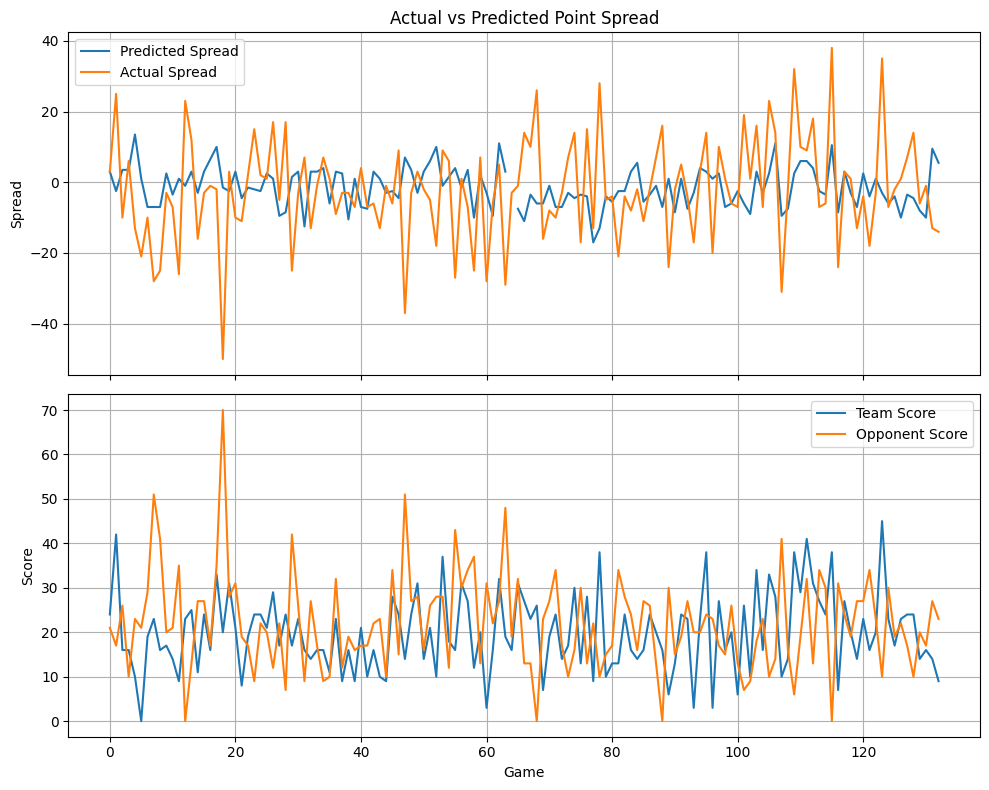

In [59]:
gamerange = np.arange(len(vegasSpread))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Top subplot: spreads
axs[0].plot(gamerange, vegasSpread, label="Predicted Spread")
axs[0].plot(gamerange, scoreDifference, label="Actual Spread")
axs[0].set_ylabel("Spread")
axs[0].set_title("Actual vs Predicted Point Spread")
axs[0].grid(True)
axs[0].legend()

# Bottom subplot: scores
axs[1].plot(gamerange, teamScoreFloat, label="Team Score")
axs[1].plot(gamerange, oppScoreFloat, label="Opponent Score")
axs[1].set_xlabel("Game")
axs[1].set_ylabel("Score")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_1779/2998285811.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,0].legend()
/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_1779/2998285811.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,0].legend()
/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_1779/2998285811.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,1].legend()
/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_1779/2998285811.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with 

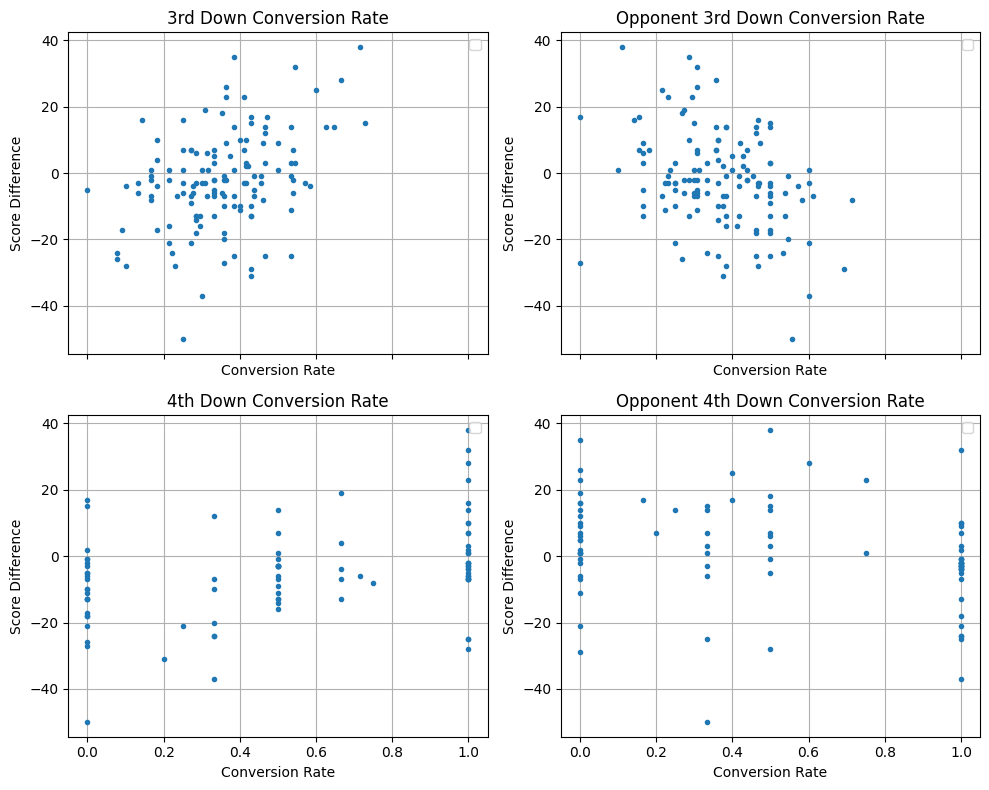

In [61]:
gamerange = np.arange(len(vegasSpread))
# fourthDownConversionRateMask = fourthDownConversionRate.is
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
# Top subplot: spreads
axs[0,0].plot(thirdDownConversionRate, scoreDifference, ".")
axs[0,0].set_ylabel("Score Difference")
axs[0,0].set_xlabel("Conversion Rate")
axs[0,0].set_title("3rd Down Conversion Rate")
axs[0,0].grid(True)
axs[0,0].legend()

# Bottom subplot: scores
axs[1,0].plot(fourthDownConversionRate, scoreDifference, ".")
axs[1,0].set_xlabel("Conversion Rate")
axs[1,0].set_ylabel("Score Difference")
axs[1,0].set_title("4th Down Conversion Rate")
axs[1,0].grid(True)
axs[1,0].legend()

# Top subplot: spreads
axs[0,1].plot(oppThirdDownConversionRate, scoreDifference, ".")
axs[0,1].set_ylabel("Score Difference")
axs[0,1].set_title("Opponent 3rd Down Conversion Rate")
axs[0,1].set_xlabel("Conversion Rate")
axs[0,1].grid(True)
axs[0,1].legend()

# Bottom subplot: scores
axs[1,1].plot(oppFourthDownConversionRate, scoreDifference, ".")
axs[1,1].set_title("Opponent 4th Down Conversion Rate")
axs[1,1].set_xlabel("Conversion Rate")
axs[1,1].set_ylabel("Score Difference")
axs[1,1].grid(True)
axs[1,1].legend()

plt.tight_layout()
plt.show()

In [54]:
fourthDownConversionRate

,0
0,NaN
1,NaN
2,0.0
3,NaN
4,0.0
...,...
128,NaN
129,0.714286
130,0.5
131,0.5


3

In [ ]:
#importing driver for webpage
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
#importing parser
from bs4 import BeautifulSoup
#importing pandas for dataframes
import pandas as pd
#delay so java script has time to load
import time
#numpy is always useful
import numpy as np
#used for pandas
from functools import reduce

import time
def getGameInfo(currID, driver):
    """
    Scrapes the game info off of PFR Including vegas lines,
        if the game was played outdoors, wind speeds ect.

    Args:
        currID (string): the HTML ID corrosponding to the targeted table
        driver (API): Selenium webdriver, specifically for chrome 

    Returns:
        dfStat: Pandas Data-Frame of all the scraped information
    """
    headersArr = []
    #reads through page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #get the passed in id in link form
    table = soup.find(id = currID)
    #strips *table header* elements
    headers = [th.text.strip() for th in table.find_all('th')]

    headersArr.append(headers)
    columnArr = []
    rows = []
    #strips all rows for each team
    for row in table.find_all('tr')[1:]:
        #td holds info, tr is the stucture
        for td in row.find_all('td'):
            columnArr.append(td.text.strip())
    if columnArr:
        rows.append(columnArr)

    dfStat = pd.DataFrame(rows, columns=np.transpose(headers))
    return dfStat


def returnEndScores(currID, driver):
    """
    Scrapes the final score of the game and passes it as home and away teams.

    Args:
        currID (string): the HTML ID corrosponding to the targeted table
        driver (API): Selenium webdriver, specifically for chrome 

    Returns:
        visitor_team (int): final score of the visiting team
        home_team (int): final score of the home team
    """

    homeTeamBool = False
    headersArr = []
    #reads through page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #get the passed in id in link form
    table = soup.find(id = currID)

    #strips *table header* elements
    headers = [th.text.strip() for th in table.find_all('th')]
    #appends it to an empty array
    headersArr.append(headers)

    #strips all rows for each team
    headers = []
    
    #Pulling the team name of the home team.
    #Used to determine is current team is home or away. 
    thead = table.find("thead")
    homeTeam = thead.find("th", {"data-stat": "home_team_score"}).text.strip()

    #pulling the last entry into the score table, meaning the final score of both the 
    # home and visitors final scores 
    tbody = table.find("tbody")
    visitor_team = tbody.find_all("td", {"data-stat": "vis_team_score"})[-1].text.strip()
    home_team = tbody.find_all("td", {"data-stat": "home_team_score"})[-1].text.strip()

    return visitor_team, home_team


def getTeamStats(currID, homeAwayBool, driver):  
   
    """
    Scrapes the game stats off of PFR for both the team of interest and their opponent
        Includes yards, turnovers, possesion time, ect. 

    Args:
        currID (string): the HTML ID corrosponding to the targeted table
        homeAwayBool (string): passed string determining if team is home or away for given week
        driver (API): Selenium webdriver, specifically for chrome 

    Returns:
        dfStat: Pandas Data-Frame of all the scraped information
    """
    defensiveHeaders = []
    headersArr = []
    #reads through page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #get the passed in id in link form
    table = soup.find(id = currID)

    #strips *table header* elements
    headers = [th.text.strip() for th in table.find_all('th')]
    
    headersArr.append(headers)

    #gets the name of each column in the table
    headers = []
    #will hold all of the values for the vistor team 
    visitor_vals = [] 
    #will hold all of the values for the home team 
    home_vals = []


    #For each entry in the table
    for row in table.find_all('tr'):
        #look at the header of the row to get what stat is representing
        stat_name = row.find('th').text.strip()
        #Get the actual information if it exists
        cols = row.find_all('td')

        #If the information exists then append relevant info to corosponding array
        if len(cols) == 2:
            #append what the stat means
            headers.append(stat_name)
            #the visitor value
            visitor_vals.append(cols[0].text.strip())
            #the home team values 
            home_vals.append(cols[1].text.strip())

    #Calls return end scores and holds it there, returns if team of interest was home
    visitorScore, HomeScore = returnEndScores("scoring", driver)
    
    # Want all the data in one row so make an opponent version of the headers. 
    defensiveHeaders = headers + [f"Opp_{h}" for h in headers]  # now double headers

    #if team of interest was home, 
    if homeAwayBool == "Home":
        #combine two rows of data into one 
        home_vals = home_vals + visitor_vals

        #creates the datafram 
        dfStat = pd.DataFrame([home_vals],
                        index=[currTeamAbbriev],
                        columns=defensiveHeaders)
        
        #Stores if team of interest was home
        dfStat["HomeTeam"] = True

        #How much the team of interest Scored
        dfStat[f"{currTeamAbbriev} Score"] = HomeScore

        #how much the opponents scored
        dfStat[f"Opp Score"] = visitorScore
    else:
        #switches stuff around specifically so team of interest is 
        #always first, makes the ML easier. Otherwise same as above
        visitor_vals = visitor_vals + home_vals
        dfStat = pd.DataFrame([visitor_vals],
                        index= [currTeamAbbriev],
                        columns=defensiveHeaders)
        dfStat["HomeTeam"] = False
        dfStat[f"{currTeamAbbriev} Score"] = visitorScore
        dfStat[f"Opp Score"] = HomeScore
    #return fininalized dataframe. 
    return dfStat

currTeamAbbriev = "CLE" 
currTeamFileName = "Browns" #IE Bills or Bengals
yearArr = [2023,2024]
#

In [4]:
for year in yearArr:
    lowercaseTeamAbbriev = currTeamAbbriev.lower()
    #options used later to simplify arguments
    # Set up headless browser which stops any GUI from apearing
    options = Options()
    options.add_argument('--headless')
    #stops Graphics processing unit from rendering the web content
    options.add_argument('--disable-gpu')

    #sets up remote control interface to instruct the behavior of web browsers
    #basically sets up functionallity to scrape web
    driver = webdriver.Chrome(options=options)

    #url that changes bassed on the inputed information that is easy to change. 
    url = f'https://www.pro-football-reference.com/teams/{lowercaseTeamAbbriev}/{year}.htm'
    driver.get(url)

    headersArr = []
    #stores when home and whens away
    homeAwayArr =[]

    #reads through page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find(id = "games")
    #strips *table header* elements
    headers = [th.text.strip() for th in table.find_all('th')]
    headersArr.append(headers)
    #strips all rows for each team
    rows = []
    boxscore_links = []


    for row in table.find_all('tr')[1:]:
        # finds each boxscore link on a teams season page
        boxscore_cell = row.find('td', {'data-stat': 'boxscore_word'})
        if boxscore_cell and boxscore_cell.find('a'):
            text = boxscore_cell.find('a').get_text(strip=True).lower()
            link = boxscore_cell.find('a')['href']
            #makes the full link then appends it to list
            if text == "boxscore":
                full_link = f"https://www.pro-football-reference.com{link}"
                boxscore_links.append(full_link)
    
    table2 = table.find_all('tr')[1:]
    for row in table2[1:]:
        homeAway = row.find('td', {'data-stat': 'game_location'}).text.strip()
        if(homeAway == "@"):
            homeAwayArr.append("Away")
        else:
            homeAwayArr.append("Home")

    #Creats the dataframes that will contain a whole season. 
    masterInfoDF = pd.DataFrame()
    masterStatsDF = pd.DataFrame()

    #for each game in the season
    for i in range(len(boxscore_links)):
        #Set up driver API to go into each game in the season
        driver.get(boxscore_links[i])
        time.sleep(2)

        #Calls for each games info
        gameInfoDF = getGameInfo("game_info", driver)
        gameStatsDF = getTeamStats("team_stats", homeAwayArr[i],driver)
        
        #Combine these into a multindex to store every game by the week it happend for a team.
        gameInfoDF.columns = pd.MultiIndex.from_product([[f"Game{i}"], gameInfoDF.columns])
        gameStatsDF.columns = pd.MultiIndex.from_product([[f"Game{i}"], gameStatsDF.columns])

        #combining dataframes into the master one
        masterInfoDF = pd.concat([masterInfoDF, gameInfoDF], axis=1)
        masterStatsDF = pd.concat([masterStatsDF, gameStatsDF], axis=1)
        print(f"Week {i} is complete")

    #Stacking each masterDF such that it is easier to view. 
    masterInfoDF = masterInfoDF.stack()
    masterStatsDF = masterStatsDF.stack()
    
    #saves this to the correct space in the Stats File. 
    masterStatsDF.to_csv(f'Stats/{currTeamFileName}/{currTeamAbbriev}TeamStats{year}.csv', index=True)
    masterInfoDF.to_csv(f'Stats/{currTeamFileName}/{currTeamAbbriev}GameInfo{year}.csv', index=True)
print("finished")

KeyboardInterrupt: 

In [5]:
#